In [1]:
from typing import Any, Dict, List, Iterable,Annotated,TypedDict,Optional
from datetime import date
from dataclasses import dataclass

import pandas as pd
from langgraph.graph import START, END, StateGraph
import operator 
import sys,os
from dotenv import load_dotenv

sys.path.append("agent")

from sql_handler import SnowflakeSQLHandler
from queries import *
from cortex import CortexConfig, SnowflakeConfig
import fetchdata_knownqueries as fetchdata

In [2]:
import logging

LOG_FILE = 'FusionDashboard.log'

load_dotenv("./agent/.env", override=True)

# Configure the logging system
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE, mode='w'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger("FusionSnowflakeDataHandler")

In [3]:
@dataclass
class DashboardDataJson:
    df_basic: str
    df_inv_agg: str
    df_monthly_inv: str
    df_ads_agg: str
    df_monthly_ads: str
    df_ga_agg: str
    df_monthly_ga: str
    df_mystery: str
    df_budget: str
    df_monthly_budget: str
    df_rank: str
    df_oem: str
    df_monthly_all: str
    df_budget_avg: str
    df_detailed_budget: str
    df_traffic_comparison: str
    df_missing_channels: str
    df_avg_monthly_sales: str
    df_mystery_monthly: str
    df_inventory_lb: str
    df_inventory_lb_state_brand_all: str
    df_inventory_lb_state_limit: str
    df_inventory_lb_brand_limit: str
    df_budget_lb: str
    df_budget_lb_state_brand_all: str
    df_budget_lb_state_limit: str
    df_budget_lb_brand_limit: str
    df_website_lb: str
    all_states_df: str
    all_brands_df: str

In [4]:
@dataclass
class StateType(Dict[str, Any]):
    context: Annotated[Dict[str, Any], operator.or_]



In [5]:
def get_sql_handler():
    """Dependency to get SQL handler instance."""
    try:
        HOST = os.environ['HOST']
        USER = os.environ['USER']
        SNOWFLAKE_ACCOUNT = os.environ['SNOWFLAKE_ACCOUNT']
        DATABASE = "CORTEX_ANALYST_DEMO"
        SCHEMA = "FUSION_DATA"
        STAGE = "RAW_DATA"
        FILE = "semantic_model_latest.yaml"
        WAREHOUSE = "COMPUTE_WH"
        ROLE = "CORTEX_USER_ROLE"

        if os.getenv("USE_PRIVATE_KEY_FILE"):
            PRIVATE_KEY_FILE = os.environ['PRIVATE_KEY_FILE']
            PRIVATE_KEY = None
            PASSPHRASE = None
        else:
            PRIVATE_KEY_FILE = None
            PRIVATE_KEY = os.environ['PRIVATE_KEY'].encode("utf-8")
            PASSPHRASE = os.environ['PRIVATE_KEY_PASSPHRASE'].encode("utf-8")
    except KeyError as e:
        raise RuntimeError(f"Missing environment variable: {e}")



    snowflake_config = SnowflakeConfig(
        SNOWFLAKE_ACCOUNT,
        USER,
        WAREHOUSE,
        ROLE,
        HOST,
        DATABASE,
        SCHEMA,
        PRIVATE_KEY_FILE,
        PRIVATE_KEY,
        PASSPHRASE)

    cortex_config = CortexConfig(
        DATABASE,
        SCHEMA,
        STAGE,
        FILE)
    try:
        handler = SnowflakeSQLHandler(snowflake_config, cortex_config)
        return handler
    except Exception as e:
        logging.error(f"Failed to create SnowflakeSQLHandler: {e}")
        raise
    finally:
        # Add any cleanup if needed
        pass

In [6]:
sql_handler = get_sql_handler()
logger.info("SQL handler initialized.")

2025-04-28 22:38:44,675 - snowflake.connector.connection - INFO - Snowflake Connector for Python Version: 3.13.2, Python Version: 3.12.9, Platform: macOS-15.3.2-arm64-arm-64bit
2025-04-28 22:38:44,676 - snowflake.connector.connection - INFO - Connecting to GLOBAL Snowflake domain
2025-04-28 22:38:44,676 - snowflake.connector.connection - INFO - This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
2025-04-28 22:38:45,177 - snowflake.core._root - INFO - New root object was created for <snowflake.connector.connection.SnowflakeConnection object at 0x15f455eb0>
2025-04-28 22:38:45,177 - snowflake.core._root - INFO - Querying the server for client info
2025-04-28 22:38:45,332 - snowflake.core._internal.telemetry - INFO - telemetry client created for <snowflake.connector.connection.SnowflakeConnection object a

In [7]:
def basic_info_node(state: StateType) -> StateType:
    """Fetch basic information."""
    logger.info("Fetching basic information...")
    
    TABLE_GROUP_NAME = "basic_info"

    config_dict = state["context"].get("config")
    if config_dict.get("DF_TABLE_GROUPS"):
        df_tables_group = config_dict.get("DF_TABLE_GROUPS", [])
        if TABLE_GROUP_NAME in df_tables_group:
            proceed = True
        else:
            proceed = False
    else:
        proceed = True
    
    print(TABLE_GROUP_NAME,proceed)
    if not proceed:
        return state    

    try:
        fullctx = state["context"]
        result = fetchdata.fetch_basic_info(fullctx,sql_handler)
    except Exception as e:
        logging.error(f"Error in fetch_basic_info: {e}")
        raise
    logging.info(f"Fetching basic information completed.")
    return {"context": result}

def inventory_data_node(state: StateType) -> StateType:
    """Fetch inventory data."""
    logger.info("Fetching inventory data...")

    TABLE_GROUP_NAME = "inventory_data"
    config_dict = state["context"].get("config")

    if config_dict.get("DF_TABLE_GROUPS"):
        df_tables_group = config_dict.get("DF_TABLE_GROUPS", [])
        if TABLE_GROUP_NAME in df_tables_group:
            proceed = True
        else:
            proceed = False
    else:
        proceed = True
    
    print(TABLE_GROUP_NAME,proceed)
    if not proceed:
        return state
    
    try:
        fullctx = state["context"]
        result = fetchdata.fetch_inventory_data(fullctx,sql_handler)
    except Exception as e:
        logging.error(f"Error in fetch_inventory_data: {e}")
        raise
    return {"context": result}

def marketing_data_node(state: StateType) -> StateType:
    """Fetch marketing data."""
    logger.info("Fetching marketing data...")

    TABLE_GROUP_NAME = "marketing_data"
    config_dict = state["context"].get("config")

    if config_dict.get("DF_TABLE_GROUPS"):
        df_tables_group = config_dict.get("DF_TABLE_GROUPS", [])
        if TABLE_GROUP_NAME in df_tables_group:
            proceed = True
        else:
            proceed = False
    else:
        proceed = True
    
    print(TABLE_GROUP_NAME,proceed)
    if not proceed:
        return state
    try:
        fullctx = state["context"]
        result = fetchdata.fetch_marketing_data(fullctx,sql_handler)
    except Exception as e:
        logging.error(f"Error in fetch_marketing_data: {e}")
        raise
    return {"context": result}

def budget_data_node(state: StateType) -> StateType:
    """Fetch budget data."""
    logger.info("Fetching budget data...")

    TABLE_GROUP_NAME = "budget_data"

    config_dict = state["context"].get("config")

    if config_dict.get("DF_TABLE_GROUPS"):
        df_tables_group = config_dict.get("DF_TABLE_GROUPS", [])
        if TABLE_GROUP_NAME in df_tables_group:
            proceed = True
        else:
            proceed = False
    else:
        proceed = True
    
    print(TABLE_GROUP_NAME,proceed)
    if not proceed:
        return state
    try:
        fullctx = state["context"]
        result = fetchdata.fetch_budget_data(fullctx,sql_handler)
    except Exception as e:
        logging.error(f"Error in fetch_budget_data: {e}")
        raise
    return {"context": result}    

def performance_data_node(state: StateType) -> StateType:
    """Fetch performance data."""
    logger.info("Fetching performance data...")

    TABLE_GROUP_NAME = "performance_data"

    config_dict = state["context"].get("config")
    if config_dict.get("DF_TABLE_GROUPS"):
        df_tables_group = config_dict.get("DF_TABLE_GROUPS", [])
        if TABLE_GROUP_NAME in df_tables_group:
            proceed = True
        else:
            proceed = False
    else:
        proceed = True
    
    print(TABLE_GROUP_NAME,proceed)
    if not proceed:
        return state
    try:
        fullctx = state["context"]
        result = fetchdata.fetch_performance_data(fullctx,sql_handler)
    except Exception as e:
        logging.error(f"Error in fetch_performance_data: {e}")
        raise
    return {"context": result}

In [8]:
def combine_results(state: StateType) -> DashboardDataJson:
    """Combine all fetched data into DescriptiveDashboardData."""
    logger.info("Combining results...")
    print("state keys:", state["context"].keys())
    #print(state)

    basic = state["context"].get("basic_info")
    inv = state["context"].get("inv_data")
    mkt = state["context"].get("marketing_data")
    budget = state["context"].get("budget_data")
    perf = state["context"].get("performance_data")
    
    result = DashboardDataJson(
        basic["df_basic"] if basic else None,
        inv["df_inv_agg"] if inv else None,
        inv["df_monthly_inv"] if inv else None,
        mkt["df_ads_agg"] if mkt else None,
        mkt["df_monthly_ads"] if mkt else None,
        mkt["df_ga_agg"] if mkt else None,
        mkt["df_monthly_ga"] if mkt else None,
        perf["df_mystery"] if perf else None,
        budget["df_budget"] if budget else None,
        budget["df_monthly_budget"] if budget else None,
        perf["df_rank"] if perf else None,
        perf["df_oem"] if perf else None,
        perf["df_monthly_all"] if perf else None,
        budget["df_budget_avg"] if budget else None,
        budget["df_detailed_budget"] if budget else None,
        mkt["df_traffic_comparison"] if mkt else None,
        perf["df_missing_channels"] if perf else None,
        perf["df_avg_monthly_sales"] if perf else None,
        perf["df_mystery_monthly"] if perf else None,
        inv["df_inventory_lb"] if inv else None,
        inv["df_inventory_lb_state_brand_all"] if inv else None,
        inv["df_inventory_lb_state_limit"] if inv else None,
        inv["df_inventory_lb_brand_limit"] if inv else None,
        budget["df_budget_lb"] if budget else None,
        budget["df_budget_lb_state_brand_all"] if budget else None,
        budget["df_budget_lb_state_limit"]   if budget else None,
        budget["df_budget_lb_brand_limit"]   if budget else None,
        mkt["df_website_lb"] if mkt else None,
        basic["all_states_df"] if basic else None,
        basic["all_brands_df"] if basic else None
    )

    #state["result"] = result
    return  result


In [9]:
from langchain_core.runnables.config import RunnableConfig


In [10]:
class ConfigSchema(TypedDict):
    DF_TABLES: Optional[List[str]]
    DF_TABLE_GROUPS: Optional[List[str]]
    DF_NL_QUERY: Optional[str]


In [11]:
def initialize_state(state: StateType,config: RunnableConfig) -> StateType:
    """Initialize state before parallel processing."""
    #print("In init state", state)
    if not state.get("context"):
        logger.error("State must contain context fields")
        raise ValueError("State must contain context fields")
    print("config",config)
    config_dict = config['configurable']
    print("config_dict",config_dict)

    logger.info("State initialized successfully.")
    return {"context": {"config" :config_dict}}

In [ ]:
def single_table_data_node(state: StateType) -> StateType:
    """Fetch single table data."""
    logger.info("Fetching single table data...")
    return state

def nl_to_sql_node(state: StateType) -> StateType:
    # sql_query = state["context"]["nl_query"]
    # sql_handler.execute_query(sql_query)
    return state
    

In [13]:
def create_dashboard_graph() -> StateGraph:
    """Create the langgraph DAG for parallel dashboard data fetching."""
    
    logger.info("Creating dashboard graph...")

    # Create the workflow graph with state type annotation
    #workflow = StateGraph(Annotated[Dict[str, Any],"DashboardState"])
    workflow = StateGraph(StateType)
    
    # Add nodes
    workflow.add_node("init", initialize_state)
    
    # Nodes for batched data fetching
    workflow.add_node("basic_info", basic_info_node)
    workflow.add_node("inventory", inventory_data_node)
    workflow.add_node("marketing", marketing_data_node)
    workflow.add_node("budget", budget_data_node)
    workflow.add_node("performance", performance_data_node)
    workflow.add_node("combine", combine_results)
    
    # Node for single table data fetching
    workflow.add_node("single_table", single_table_data_node)

    # Node for NL to SQL conversion
    workflow.add_node("nl_to_sql", nl_to_sql_node)

    workflow.add_edge(START, "init")
    
    # Fan-out from init
    for node in ["basic_info", "marketing","inventory", "budget", "performance"]:
        workflow.add_edge("init", node)

    # Add edges from parallel nodes to combine with condition
    for node in ["basic_info", "marketing","inventory", "budget", "performance"]:
        workflow.add_edge(node,"combine")

    workflow.add_edge("init", "single_table")
    workflow.add_edge("init", "nl_to_sql")
    
    workflow.add_edge("single_table", END)
    workflow.add_edge("nl_to_sql", END)

    workflow.add_edge("combine", END)
    
    logger.info("Dashboard graph created successfully.")
    return workflow.compile()

In [14]:
info_pl= {"context": {
        "jira_id": "JML",
        "start_date": "2024-04-01",
        "end_date": "2025-03-31",
        "ai_insight_lb_limit": 50,
        "state":"Florida",
        "brand":"Lexus"
    }}

# Create and run the graph
#graph = create_datafetcher_graph()
graph = create_dashboard_graph()
graph.name = "FusionDashboardGraph" 


2025-04-28 22:38:45,384 - FusionSnowflakeDataHandler - INFO - Creating dashboard graph...
2025-04-28 22:38:45,385 - FusionSnowflakeDataHandler - INFO - Dashboard graph created successfully.


In [18]:
config = {}
# config = {"DF_TABLE_GROUPS":["basic_info","performance_data","performance_data"]}

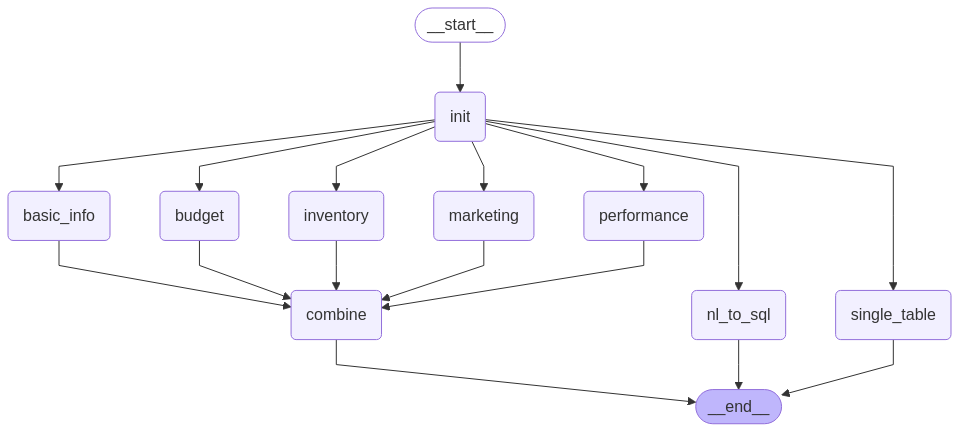

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [20]:
result = graph.invoke(info_pl,config)

config {'metadata': {'langgraph_step': 1, 'langgraph_node': 'init', 'langgraph_triggers': ('branch:to:init',), 'langgraph_path': ('__pregel_pull', 'init'), 'langgraph_checkpoint_ns': 'init:237be1cf-3531-2890-f413-2e2c76760b95'}, 'configurable': {'__pregel_task_id': '237be1cf-3531-2890-f413-2e2c76760b95', '__pregel_send': functools.partial(<function local_write at 0x118398680>, <built-in method extend of collections.deque object at 0x1691ee980>, ('__start__', 'init', 'basic_info', 'inventory', 'marketing', 'budget', 'performance', 'combine', 'single_table', 'nl_to_sql')), '__pregel_read': functools.partial(<function local_read at 0x1183985e0>, {'context': <langgraph.channels.binop.BinaryOperatorAggregate object at 0x16916e680>, '__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x16916adc0>, 'branch:to:init': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x16922abc0>, 'branch:to:basic_info': <langgraph.channels.ephemeral_value.EphemeralValue object 

KeyError: 'nl_query'

In [ ]:
result

{'context': {'jira_id': 'JML',
  'start_date': '2024-04-01',
  'end_date': '2025-03-31',
  'ai_insight_lb_limit': 50,
  'state': 'Florida',
  'brand': 'Lexus',
  'config': {'DF_TABLE_GROUPS': ['basic_info',
    'performance_data',
    'performance_data'],
   '__pregel_task_id': '9f7a9848-e5b8-c27a-e999-4d3474e72cd8',
   '__pregel_send': functools.partial(<function local_write at 0x11989c5e0>, <built-in method extend of collections.deque object at 0x13f59f790>, ('__start__', 'init', 'basic_info', 'inventory', 'marketing', 'budget', 'performance', 'combine', 'single_table', 'nl_to_sql')),
   '__pregel_read': functools.partial(<function local_read at 0x11989c540>, {'context': <langgraph.channels.binop.BinaryOperatorAggregate object at 0x13a271ac0>, '__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x13a273480>, 'branch:to:init': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x13a271780>, 'branch:to:basic_info': <langgraph.channels.ephemeral_value.Eph

In [ ]:
sql_handler.execute_query("Find the total number of unique dealers",save_to_downloads,simple_logger)

2025-04-28 22:03:53,486 - transitions.core - INFO - Finished processing state GENERATE_SQL_CORTEX exit callbacks.
2025-04-28 22:03:53,488 - fusion - INFO - [State: GENERATE_SQL_CORTEX] Attempt #1
2025-04-28 22:03:53,802 - fusion - WARNING - Cortex session expired, retrying...
2025-04-28 22:03:53,804 - snowflake.connector.connection - INFO - closed
2025-04-28 22:03:54,253 - snowflake.connector.connection - INFO - No async queries seem to be running, deleting session
2025-04-28 22:03:54,362 - snowflake.connector.connection - INFO - Snowflake Connector for Python Version: 3.13.2, Python Version: 3.12.9, Platform: macOS-15.3.2-arm64-arm-64bit
2025-04-28 22:03:54,363 - snowflake.connector.connection - INFO - Connecting to GLOBAL Snowflake domain
2025-04-28 22:03:54,363 - snowflake.connector.connection - INFO - This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder 

22:04:00 - LiteLLM:INFO: utils.py:3075 - 
LiteLLM completion() model= claude-3-7-sonnet-20250219; provider = anthropic


2025-04-28 22:04:00,553 - LiteLLM - INFO - 
LiteLLM completion() model= claude-3-7-sonnet-20250219; provider = anthropic


22:04:00 - LiteLLM:INFO: utils.py:3075 - 
LiteLLM completion() model= claude-3-7-sonnet-20250219; provider = anthropic


2025-04-28 22:04:00,564 - LiteLLM - INFO - 
LiteLLM completion() model= claude-3-7-sonnet-20250219; provider = anthropic
2025-04-28 22:04:00,573 - fusion - ERROR - SQL Error: litellm.AuthenticationError: Missing Anthropic API Key - A call is being made to anthropic but no key is set either in the environment variables or via params. Please set `ANTHROPIC_API_KEY` in your environment vars
2025-04-28 22:04:00,573 - fusion - ERROR - Failed to execute query state machine
Traceback (most recent call last):
  File "/Users/bhaskardutta/miniconda3/envs/fusion/lib/python3.12/site-packages/dspy/adapters/chat_adapter.py", line 49, in __call__
    return super().__call__(lm, lm_kwargs, signature, demos, inputs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bhaskardutta/miniconda3/envs/fusion/lib/python3.12/site-packages/dspy/adapters/base.py", line 26, in __call__
    outputs = lm(**inputs_, **lm_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/

{'resultsArray': [{}]}

In [ ]:
def simple_logger(logs: list[dict]) -> None:
    for entry in logs:
        print(entry)

In [ ]:
import os
import uuid
import shutil
from typing import IO

def save_to_downloads(file_obj: IO) -> str:
    """Save a file-like object to the user's Downloads folder and return the full path."""

    # Determine the user's Downloads folder
    downloads_folder = os.path.join(os.path.expanduser("~"), "Downloads")

    # Ensure Downloads folder exists
    os.makedirs(downloads_folder, exist_ok=True)

    # Generate a unique filename
    filename = f"query_result_{uuid.uuid4().hex}.csv"
    file_path = os.path.join(downloads_folder, filename)

    # Write the contents from file_obj to the new file
    with open(file_path, "wb") as f:
        # Move back to the start of the in-memory file
        file_obj.seek(0)
        shutil.copyfileobj(file_obj, f)

    return file_path  # Return the full path to the saved file